In [1]:
import sys,os,glob
import subprocess

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.colors import LogNorm,Normalize,SymLogNorm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid

import pandas as pd
import xarray as xr

import astropy.constants as ac
import astropy.units as au

from IPython import get_ipython
ipython = get_ipython()

# If in ipython, load autoreload extension
if 'ipython' in globals():
    ipython.magic('load_ext autoreload')
    ipython.magic('autoreload 2')

# Display all cell outputs in notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

In [2]:
plt.rcParams['figure.dpi']=200
plt.rcParams['mathtext.fontset']='cm'
plt.rcParams['font.size']=16

In [3]:
import pyathena as pa
coolftn=pa.coolftn()
units=pa.set_units(muH=1.4271)
to_Myr=units['time'].to('Myr').value
to_Msun=units['mass'].to('Msun').value
to_uG=units['magnetic_field'].value
to_pok=units['pressure'].cgs.value/ac.k_B.cgs.value
to_T1=(units['pressure']/units['density']*ac.m_p/ac.k_B).cgs.value

eta_conv=(ac.M_sun/ac.kpc**2/au.yr*au.km/au.s/ac.k_B).cgs.value

In [4]:
class vizdata(object):
    def __init__(self,pid,itime,base='/tigress/changgoo/',pdir=None,vtkdir=None,Omega=0.028):

        if pdir is None:
            pdir=pid
        if vtkdir is None:
            vtkdir=base+pdir
        self.pid=pid
        self.pdir=pdir+'/'
        self.base=base
        self.vtkdir=vtkdir
        self.itime=itime
        self.par=pa.get_params('{}{}/{}.par'.format(base,pdir,pid))
        if 'Omega' in self.par:
            self.Omega=self.par['Omega']
        else:
            self.Omega=Omega
        self.torb=2*np.pi/self.Omega

    def readhst(self):
        pid=self.pid
        pdir=self.pdir
        base=self.base
        itime=self.itime
        self.hst=pd.read_pickle('{}{}/hst/{}.hst.p'.format(base,pdir,pid))
        self.hzp=pd.read_pickle('{}{}/hst/{}.hst_zp.p'.format(base,pdir,pid))
        self.sn=pd.read_pickle('{}{}/hst/{}.sn.p'.format(base,pdir,pid))

    def readall(self):
        pid=self.pid
        pdir=self.pdir
        base=self.base
        itime=self.itime
        
        self.readhst()
        self.ds=pa.AthenaDataSet('{}/id0/{}.{:04d}.vtk'.format(self.vtkdir,pid,itime))
        self.sp=pa.read_starvtk('{}{}/starpar/{}.{:04d}.starpar.vtk'.format(base,pdir,pid,itime))
        self.slc=pd.read_pickle('{}{}/slice/{}.{:04d}.slice.p'.format(base,pdir,pid,itime))
        self.surf=pd.read_pickle('{}{}/surf/{}.{:04d}.surf.p'.format(base,pdir,pid,itime))
        
        dm=self.ds.domain
        self.yoffset=-np.mod(dm['time']*self.Omega*dm['Lx'][0],dm['Lx'][1])
        self.joffset=int(self.yoffset/dm['dx'][1])

### for additional colormaps, I installed

* [cmoecean](https://matplotlib.org/cmocean/#installation)
* [cMasher](https://cmasher.readthedocs.io/user/introduction.html#how-to-install)

In [5]:
import cmocean.cm as cmo
import cmasher.cm as cma
from matplotlib.pyplot import cm

# slices for all models (normalized by scale height)

In [6]:
def plot_image(sim,ax,cutaxis='z',scafield='nH',vecfield='',
               yshift=0,log=True,colorbars=True,
               clusters=False,runaways=False,
               scaleH=1.,xrange=None,yrange=None,
               im_kw=dict(),st_kw=dict()):
    if cutaxis != 'z': yshift=0
    scal=np.roll(sim.slc[cutaxis][scafield],sim.joffset*yshift,axis=0)
    
    if log: scal=np.log10(scal)
    xmin,xmax,ymin,ymax=sim.slc[cutaxis+'extent']
    Ly=ymax-ymin
    Ny,Nx=scal.shape
    xfc=np.linspace(xmin,xmax,Nx+1)
    yfc=np.linspace(ymin,ymax,Ny+1)
    xcc=0.5*(xfc[1:]+xfc[:-1])
    ycc=0.5*(yfc[1:]+yfc[:-1])
    if xrange != None:
        xidx=((xcc/scaleH)>xrange[0]) & ((xcc/scaleH)<xrange[1])
        scal = scal[:,xidx]
        xmin=max(xrange[0]*scaleH,xmin)
        xmax=min(xrange[1]*scaleH,xmax)
    if yrange != None:
        yidx=((ycc/scaleH)>yrange[0]) & ((ycc/scaleH)<yrange[1])
        scal = scal[yidx,:]
        ymin=max(yrange[0]*scaleH,ymin)
        ymax=min(yrange[1]*scaleH,ymax)


    im=ax.imshow(scal,extent=[xmin/scaleH,xmax/scaleH,ymin/scaleH,ymax/scaleH],origin='lower',**im_kw)
    cbar_collection=[im]

    axarr=np.array(['x','y','z'])
    xaxis,yaxis=axarr[axarr != cutaxis]
    if vecfield+'_x' in sim.slc[cutaxis]:

        vx = np.roll(sim.slc[cutaxis][vecfield+'_'+xaxis],sim.joffset*yshift,axis=0)
        vy = np.roll(sim.slc[cutaxis][vecfield+'_'+yaxis],sim.joffset*yshift,axis=0)
        
        if xrange != None:
            xidx=((xcc/scaleH)>xrange[0]) & ((xcc/scaleH)<xrange[1])
            xcc = xcc[xidx]
            vx = vx[:,xidx]
            vy = vy[:,xidx]
        if yrange != None:
            yidx=((ycc/scaleH)>yrange[0]) & ((ycc/scaleH)<yrange[1])
            ycc = ycc[yidx]
            vx = vx[yidx,:]
            vy = vy[yidx,:]

        vmag = np.sqrt(vx**2+vy**2)
        if vecfield == 'velocity':
            lw=np.log10(vmag)/2.+0.5
            vmag = vy*(ycc[:,np.newaxis]/np.abs(ycc[:,np.newaxis]))
        elif vecfield == 'magnetic_field':
            vmag *= to_uG
            lw=np.log10(vmag)
        st=ax.streamplot(xcc/scaleH,ycc/scaleH,vx,vy,color=vmag,linewidth=lw,**st_kw)
        cbar_collection.append(st.lines)
    if clusters & (len(sim.sp)>0):
        plot_clusters(sim,ax,xaxis,yaxis,sim.yoffset*yshift/1.e3,Ly*yshift,scale=scaleH*1.e3)
    if runaways & (len(sim.sp)>0):
        plot_runaways(sim,ax,xaxis,yaxis,sim.yoffset*yshift/1.e3,Ly*yshift,scale=scaleH*1.e3)
    ax.set_xlim(xmin/scaleH,xmax/scaleH)
    ax.set_ylim(ymin/scaleH,ymax/scaleH)
    ax.set_aspect('equal')
    #ax.axis('off')
    if colorbars:
        for coll,loc in zip(cbar_collection,[1,4]):
            if cutaxis == 'z':
                cax = inset_axes(ax,width="30%",height="3%",loc=loc)
                cbar=plt.colorbar(coll,cax=cax,orientation='horizontal')
            else:
                cax = inset_axes(ax,width="10%",height="10%",loc=loc)
                cbar=plt.colorbar(coll,cax=cax,orientation='vertical')
                cax.yaxis.tick_left()
                cax.yaxis.set_label_position('left')
            if (loc == 4) & (cutaxis == 'z'):
                cax.xaxis.tick_top()
                cax.xaxis.set_label_position('top')
            set_axis_color(cax,'xy','k')
            cbar.outline.set_edgecolor('k')
            if scafield in ['nH','pok','mag_pok','ram_pok_z','magnetic_field_strength']:
                set_axis_color(cax,'xy','w')
                cbar.outline.set_edgecolor('w')
    return cbar_collection

In [7]:
def slice_all(models,torb,scafield,vecfield,style):

    fig,axes=plt.subplots(1,7,figsize=(11,10),num=0,
                      gridspec_kw=dict(left=0.06,right=0.94,top=0.9,bottom=0.1,wspace=0.0))
    for k,ax in zip(['R2','LGR2','R4','LGR4','R8','LGR8','R16'],axes): 
        sim=vizdata(models[k]['pid'],0)
        if torb < 0:
            sim=models[k]['sim']
        else:
            itime=int(torb*sim.torb/dt[k])
            sim=vizdata(models[k]['pid'],itime)
            sim.readall()
            models[k]['sim']=sim

        H=np.nanmean(sim.hzp['H'][(sim.hzp.index > 0.5*sim.torb) & (sim.hzp.index < 1.5*sim.torb)])/1.e3
        
        if vecfield in style:
            st_kw=style[vecfield]
        else:
            st_kw=None
        cb=plot_image(sim,ax,cutaxis='y',vecfield=vecfield,scafield=scafield,
                      log=False,scaleH=H,yrange=[-4,4],xrange=[-0.6,0.6],
                      im_kw=style[scafield],st_kw=st_kw,colorbars=False,)
        ax.set_ylim(-4,4)
        ax.set_xlim(-0.6,0.6)

        ax.annotate(k,(0.5,0.98),xycoords='axes fraction',ha='center',va='top',**pa.texteffect('medium'))
        if k == 'LGR4': ax.set_xlabel(r'$x/H$',fontsize='x-large')

        plt.sca(ax)
        if k == 'R2':
            plt.tick_params(axis='both',which='both',left=True,bottom=True,right=False,top=False)
        elif k == 'R16':        
            plt.tick_params(axis='both',which='both',right=True,bottom=True,left=False,top=False)        
        else:
            ax.spines['left'].set_color('none')
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            plt.sca(ax)
            plt.yticks([])
            plt.tick_params(axis='both',which='both',right=False,bottom=True,left=False,top=False)        
            plt.setp(ax.get_yticklabels(),visible=False)
        plt.xticks(rotation=45)

    ax=axes[0]
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.tick_left()
    ax.yaxis.set_label_position('left')

    ax.set_ylabel(r'$z/H$',fontsize='x-large')

    ax=axes[-1]
    ax.spines['left'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

    ax.set_ylabel(r'$z/H$',fontsize='x-large')

    if torb < 0:
        cax1=fig.add_axes([0.15,0.945,0.3,0.02])
    else:
        cax1=fig.add_axes([0.12,0.945,0.25,0.02])
        plt.annotate(r'$t/t_{{\rm orb}}={:5.2f}$'.format(torb),(0.5,0.945),
                     xycoords='figure fraction',
                     ha='center',va='bottom',fontsize='large')
    cbar1=fig.colorbar(cb[0],cax=cax1,orientation='horizontal')
    cax1.xaxis.tick_top()
    cbar1.set_label(style[scafield]['label'])
    if len(cb)>1:
        if torb < 0:
            cax2=fig.add_axes([0.55,0.945,0.3,0.02])
        else:
            cax2=fig.add_axes([0.63,0.945,0.25,0.02])
        cbar2=fig.colorbar(cb[1],cax=cax2,orientation='horizontal')
        cax2.xaxis.tick_top()
        cbar2.set_label()
    return fig

In [8]:
models={'R2': {'pid': 'R2_2pc_L512_B2_norun'},
         'R4': {'pid': 'R4_2pc_L512_B10'},
         'R8': {'pid': 'R8_4pc_newacc'},
         'R16': {'pid': 'R16_8pc_metal'},
         'LGR2': {'pid': 'LGR2_2pc_L512_B10'},
         'LGR4': {'pid': 'LGR4_2pc_L512_B10'},
         'LGR8': {'pid': 'LGR8_4pc_FUVcorr'}}

# vtk dump interval
dt=dict(R2=0.2,R4=0.5,R8=1,R16=3,LGR2=0.5,LGR4=1,LGR8=2)

In [37]:
# select the closest snapshot for a given torb
from pyathena.create_pickle import *

torb=0.6
for k in models:
    sim=vizdata(models[k]['pid'],100)
    itime=int(torb*2.*np.pi/sim.Omega/dt[k])
    sim=vizdata(models[k]['pid'],itime)
    sim.readall()
    models[k]['sim']=sim
    print(k,itime,'magnetic_field_z' in sim.slc['x'])
    
    # re-create slices if there is no magnetic field information
    if 'magnetic_field_z' in sim.slc['x']:
        pass
    else:
        kwargs=dict(base_directory=sim.base,directory=sim.pdir,
                    id=sim.pid,rotation=sim.Omega,
                    range='{},{},1'.format(sim.itime,sim.itime+1))
        create_all_pickles(force_recal=True,**kwargs)
        # re-read
        sim.readall()
        
    # add missing quantities
    for cutax in ['x','y','z']:
        sim.slc[cutax]['mag_pok']=0.5*(sim.slc[cutax]['magnetic_field_x']**2+
                                         sim.slc[cutax]['magnetic_field_y']**2+
                                         sim.slc[cutax]['magnetic_field_z']**2)*to_Pok
        sim.slc[cutax]['pimag_pok']=sim.slc[cutax]['mag_pok']-sim.slc[cutax]['magnetic_field_z']**2*to_pok
        sim.slc[cutax]['ptot']=sim.slc[cutax]['pok']+sim.slc[cutax]['ram_pok_z']+sim.slc[cutax]['pimag_pok']

R2 188 True
R4 140 True
R8 134 True
R16 106 True
LGR2 150 True
LGR4 125 True
LGR8 125 True


In [10]:
style_light=dict(nH=dict(norm=LogNorm(1.e-4,1.e4),cmap=cma.jungle_r,
                        label=r'$n_H\,[{\rm cm^{-3}}]$'),
                 velocity=dict(norm=SymLogNorm(linthresh=1.,vmin=-500,vmax=500),
                               cmap=cm.RdBu_r,density=2,label=r'$v_{\rm out}\,[{\rm km/s}]$'),
                 temperature=dict(norm=LogNorm(100,1.e8),cmap=cm.RdBu_r,label=r'$T\,[{\rm K}]$'),
                 pok=dict(norm=LogNorm(1.e2,1.e7),cmap=cm.plasma,
                          label=r'$P_{\rm th}/k_B\,[{\rm cm^{-3}\,K}]$'),
                 ptot=dict(norm=LogNorm(1.e2,1.e7),cmap=cm.plasma,
                          label=r'$P_{\rm tot}/k_B\,[{\rm cm^{-3}\,K}]$'),
                  ram_pok_z=dict(norm=LogNorm(1.e2,1.e7),cmap=cm.plasma,
                          label=r'$P_{\rm turb}/k_B\,[{\rm cm^{-3}\,K}]$'),
                  mag_pok=dict(norm=LogNorm(1.e2,1.e7),cmap=cm.plasma,
                          label=r'$P_{\rm mag}/k_B\,[{\rm cm^{-3}\,K}]$'),
                pimag_pok=dict(norm=SymLogNorm(1.,vmin=-1.e6,vmax=1.e6),cmap=cm.RdBu_r,
                          label=r'$\Pi_{\rm mag}/k_B\,[{\rm cm^{-3}\,K}]$'),
                )
style_dark=dict(nH=dict(norm=LogNorm(1.e-4,1.e2),cmap=cma.rainforest),
                velocity=dict(norm=SymLogNorm(linthresh=1.,vmin=-500,vmax=500),cmap=cma.redshift,density=2),
                temperature=dict(norm=LogNorm(100,1.e8),cmap=cma.fusion_r),)

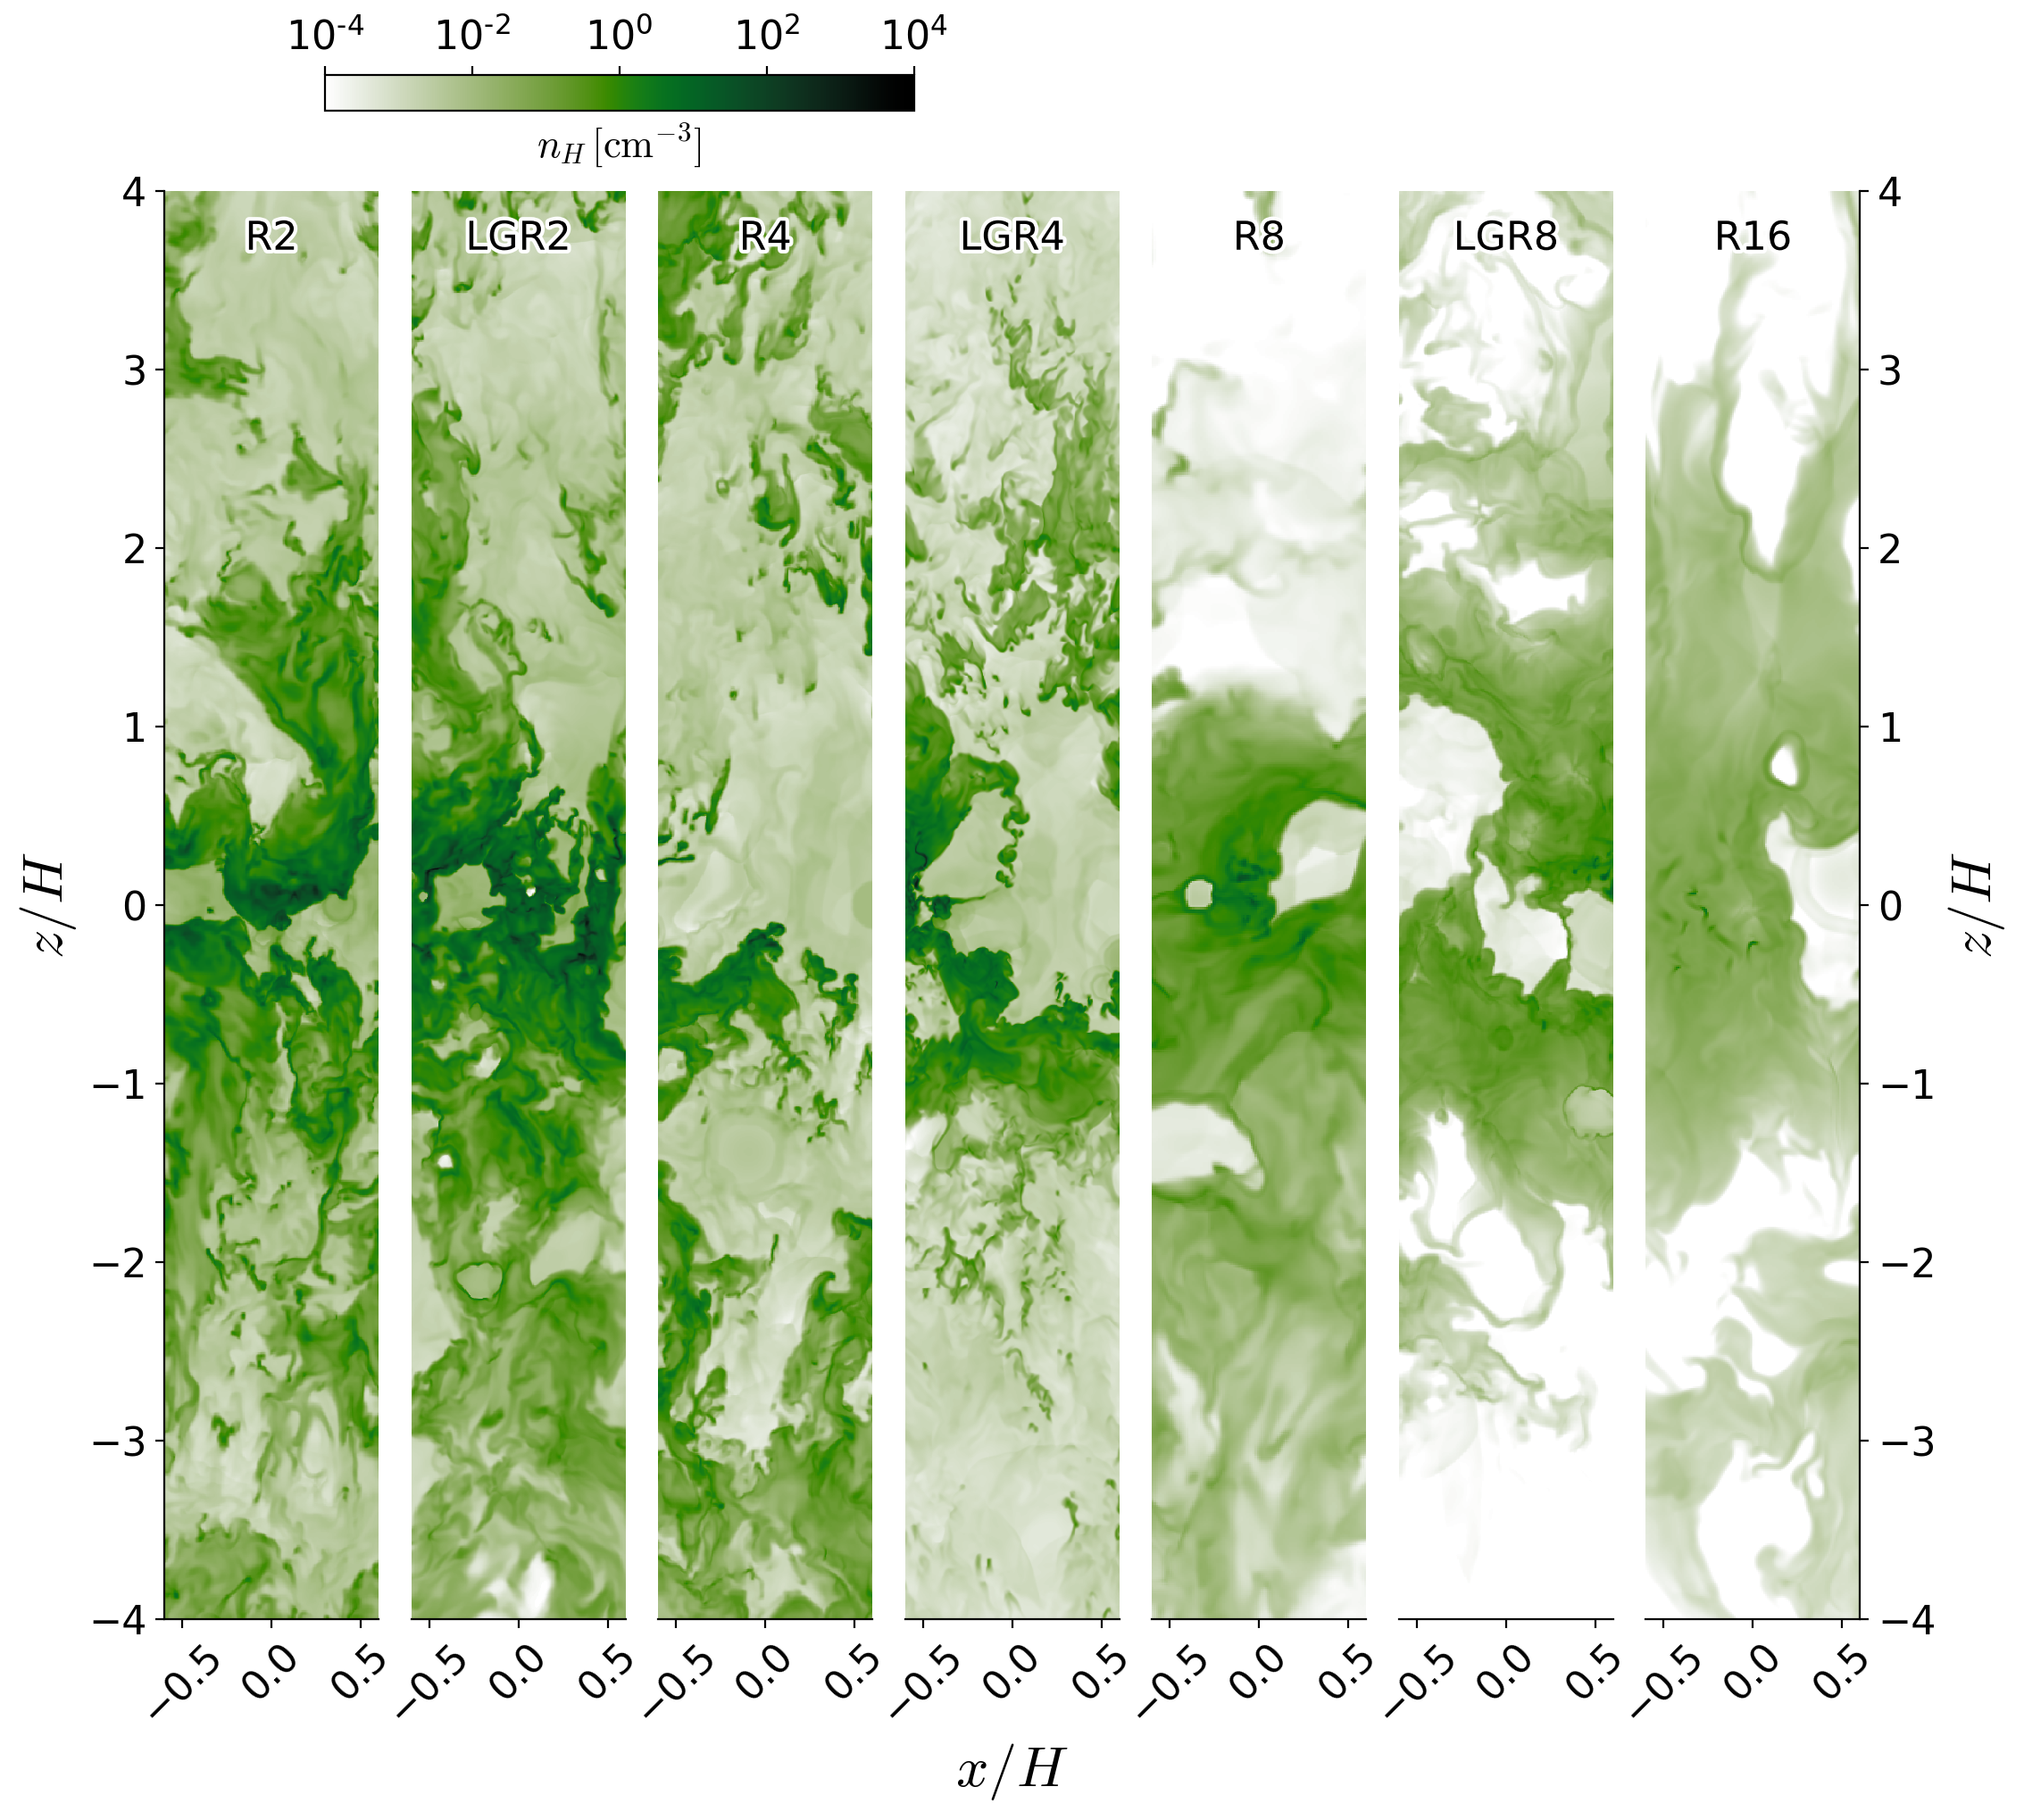

In [11]:
fig=slice_all(models,-1,'nH','',style_light)
# figfile='../figures/slice_all_d.png'
# fig.savefig(figfile)

In [38]:
s=models['R2']['sim']

In [39]:
B=s.ds.read_all_data('magnetic_field')

In [40]:
Pmag=0.5*np.sum(B**2,axis=-1)

In [41]:
Pimag = Pmag - B[...,-1]**2

In [44]:
B[:,128,:,-1]

array([[ 7.5167108,  7.517302 ,  7.631762 , ..., -4.558436 , -4.611145 ,
        -4.5925817],
       [ 7.6395516,  7.5437694,  7.5683265, ..., -4.2937927, -4.2802076,
        -4.2161875],
       [ 7.832985 ,  7.6037   ,  7.5513787, ..., -4.1356025, -4.0463967,
        -3.9204957],
       ...,
       [ 7.586759 ,  6.347416 ,  5.7185197, ..., 14.720329 , 15.3795395,
        15.635788 ],
       [ 9.960474 ,  8.315049 ,  6.980897 , ..., 14.910303 , 14.89621  ,
        14.765544 ],
       [12.059656 , 10.463861 ,  8.684443 , ..., 14.900232 , 14.38417  ,
        14.06174  ]], dtype=float32)

In [42]:
s.slc['y']['magnetic_field_z']

array([[ 7.897831 ,  7.9328046,  8.032484 , ..., -4.4893537, -4.5637856,
        -4.5361023],
       [ 8.05045  ,  7.989743 ,  7.9992642, ..., -4.283916 , -4.2963886,
        -4.2042117],
       [ 8.240312 ,  8.083178 ,  8.038967 , ..., -4.185391 , -4.1291165,
        -3.9554408],
       ...,
       [10.199034 ,  8.474201 ,  7.1104255, ..., 14.485247 , 15.497909 ,
        16.001373 ],
       [12.359566 , 10.745619 ,  8.706773 , ..., 14.625799 , 15.253074 ,
        15.277853 ],
       [13.815931 , 12.81933  , 10.716312 , ..., 14.707388 , 14.754609 ,
        14.553851 ]], dtype=float32)

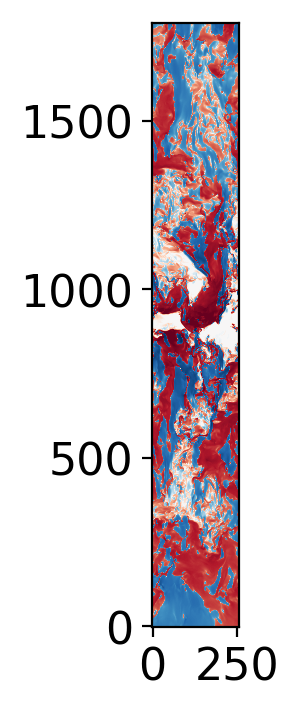

In [45]:
plt.imshow(Pimag[:,128,:]*to_Pok,origin='lower',**style_light['pimag_pok'])

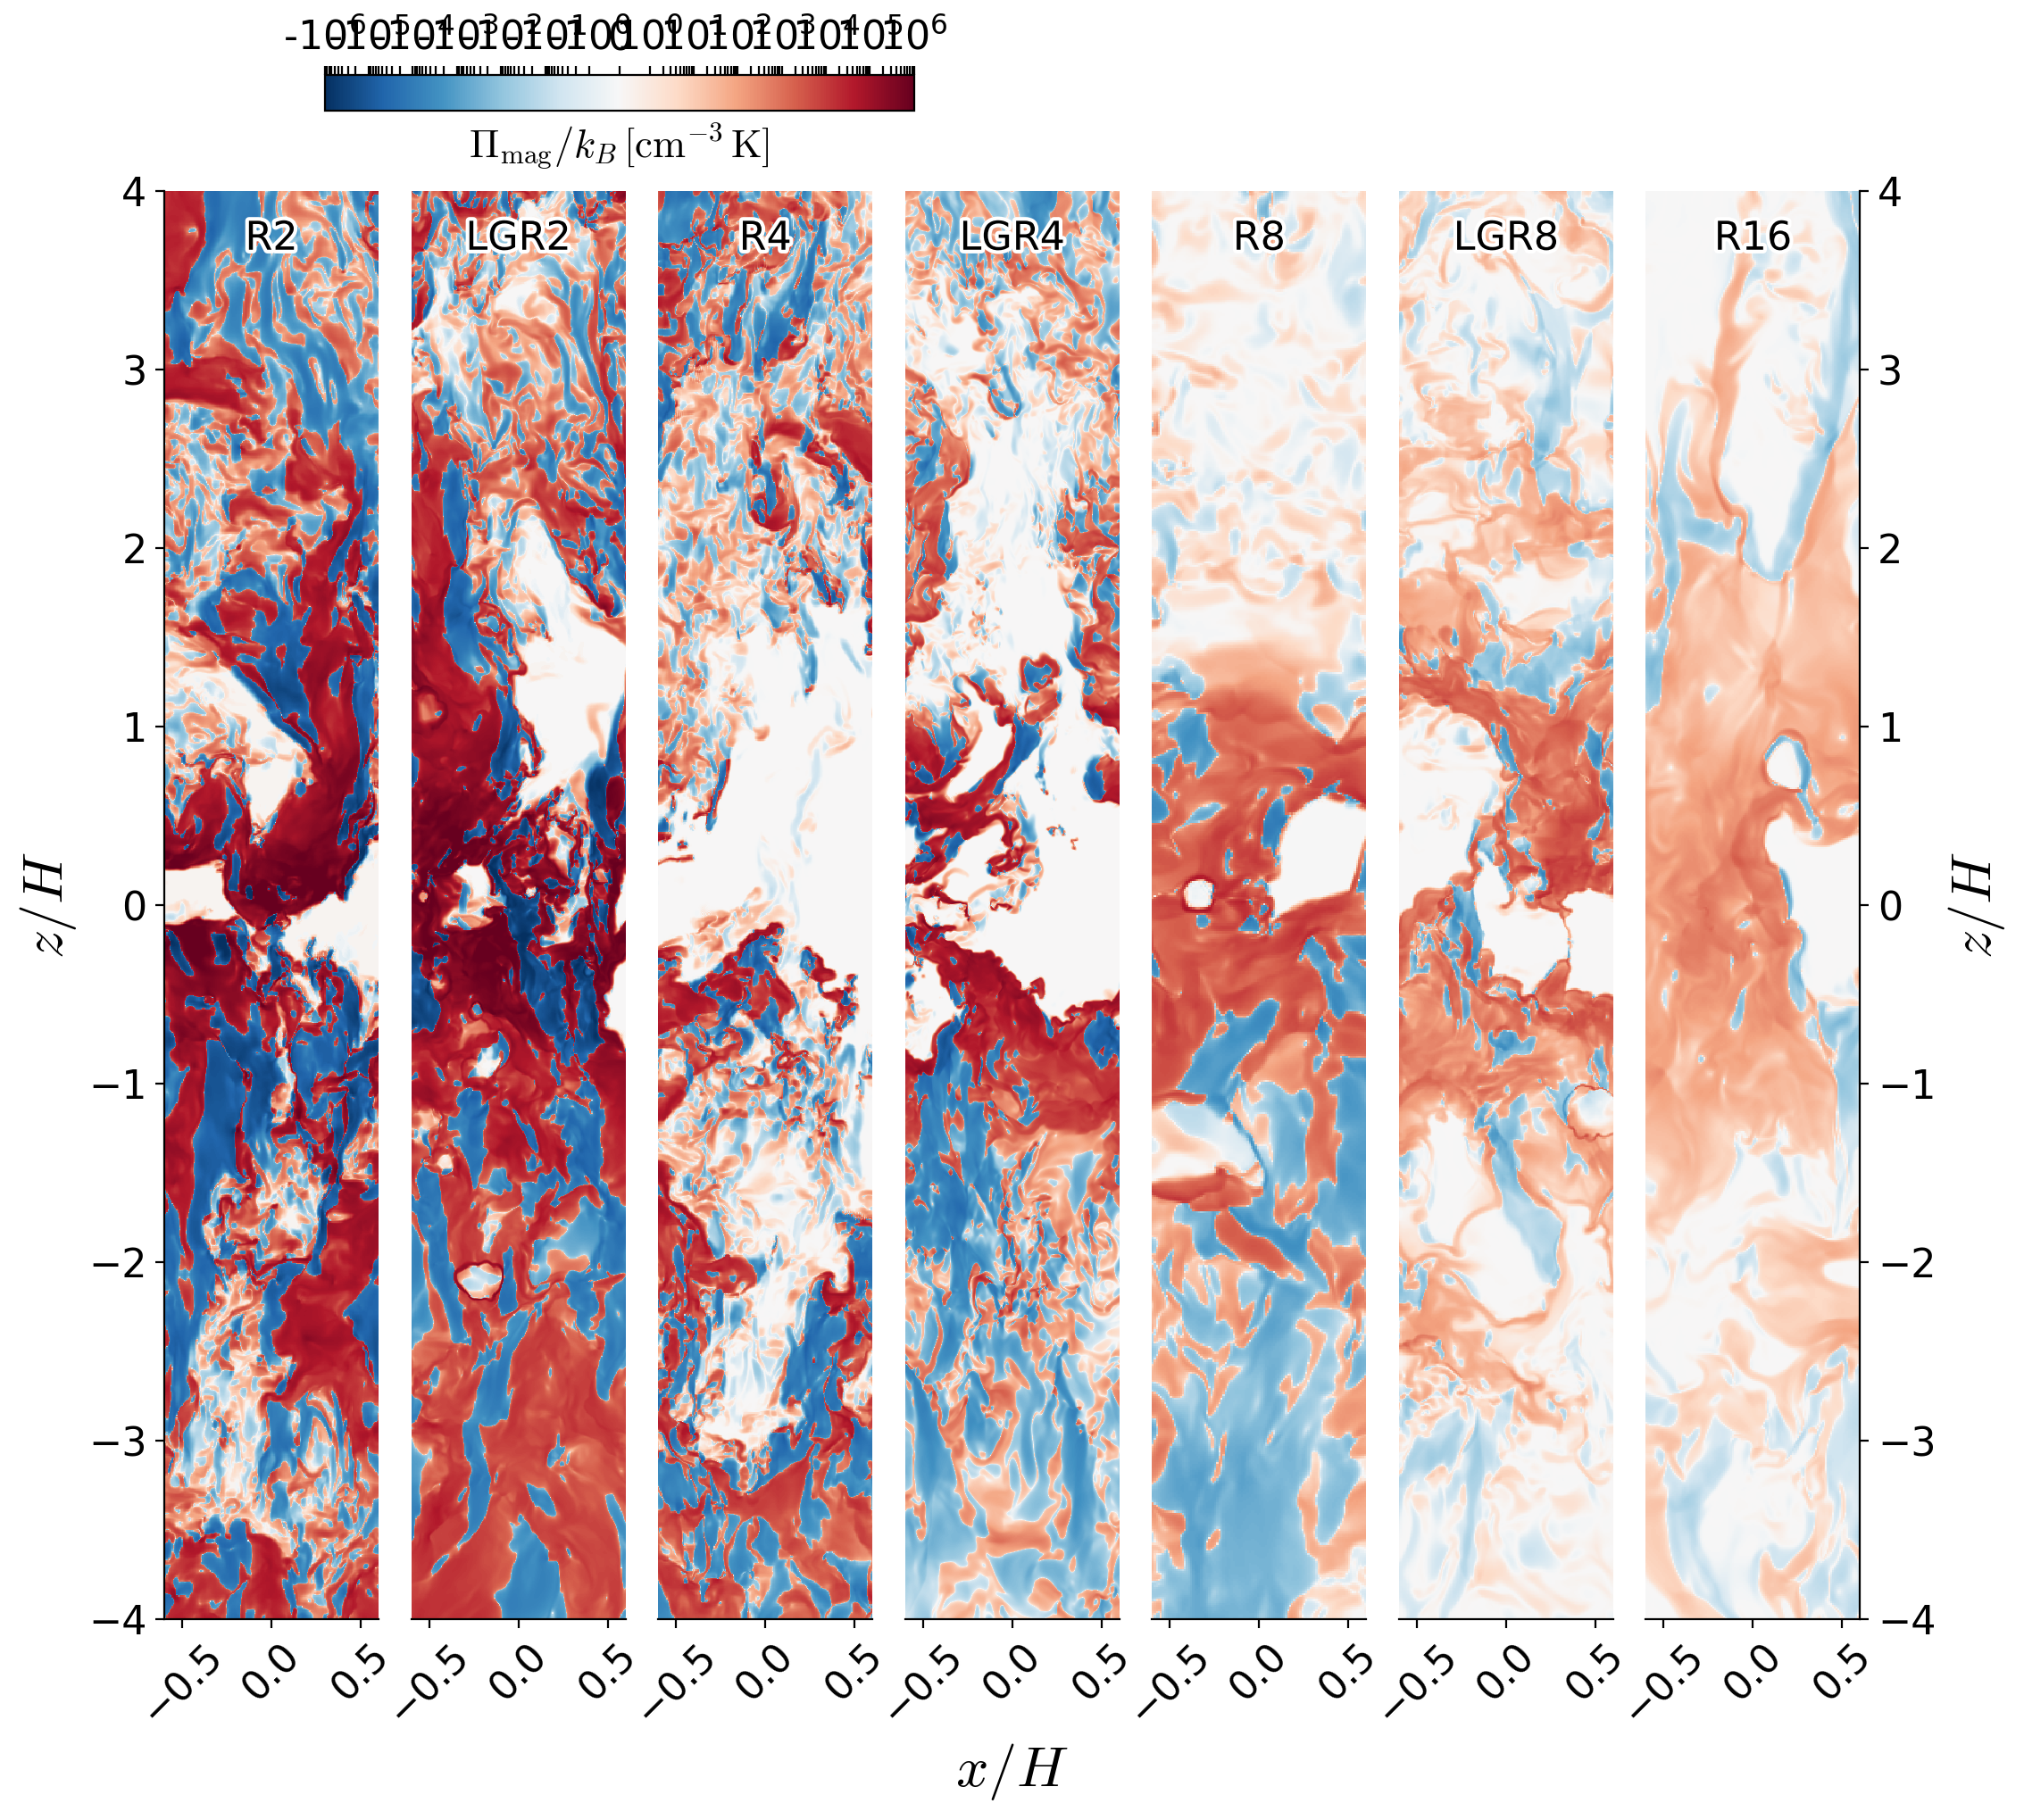

In [46]:
fig=slice_all(models,-1,'pimag_pok','',style_light)

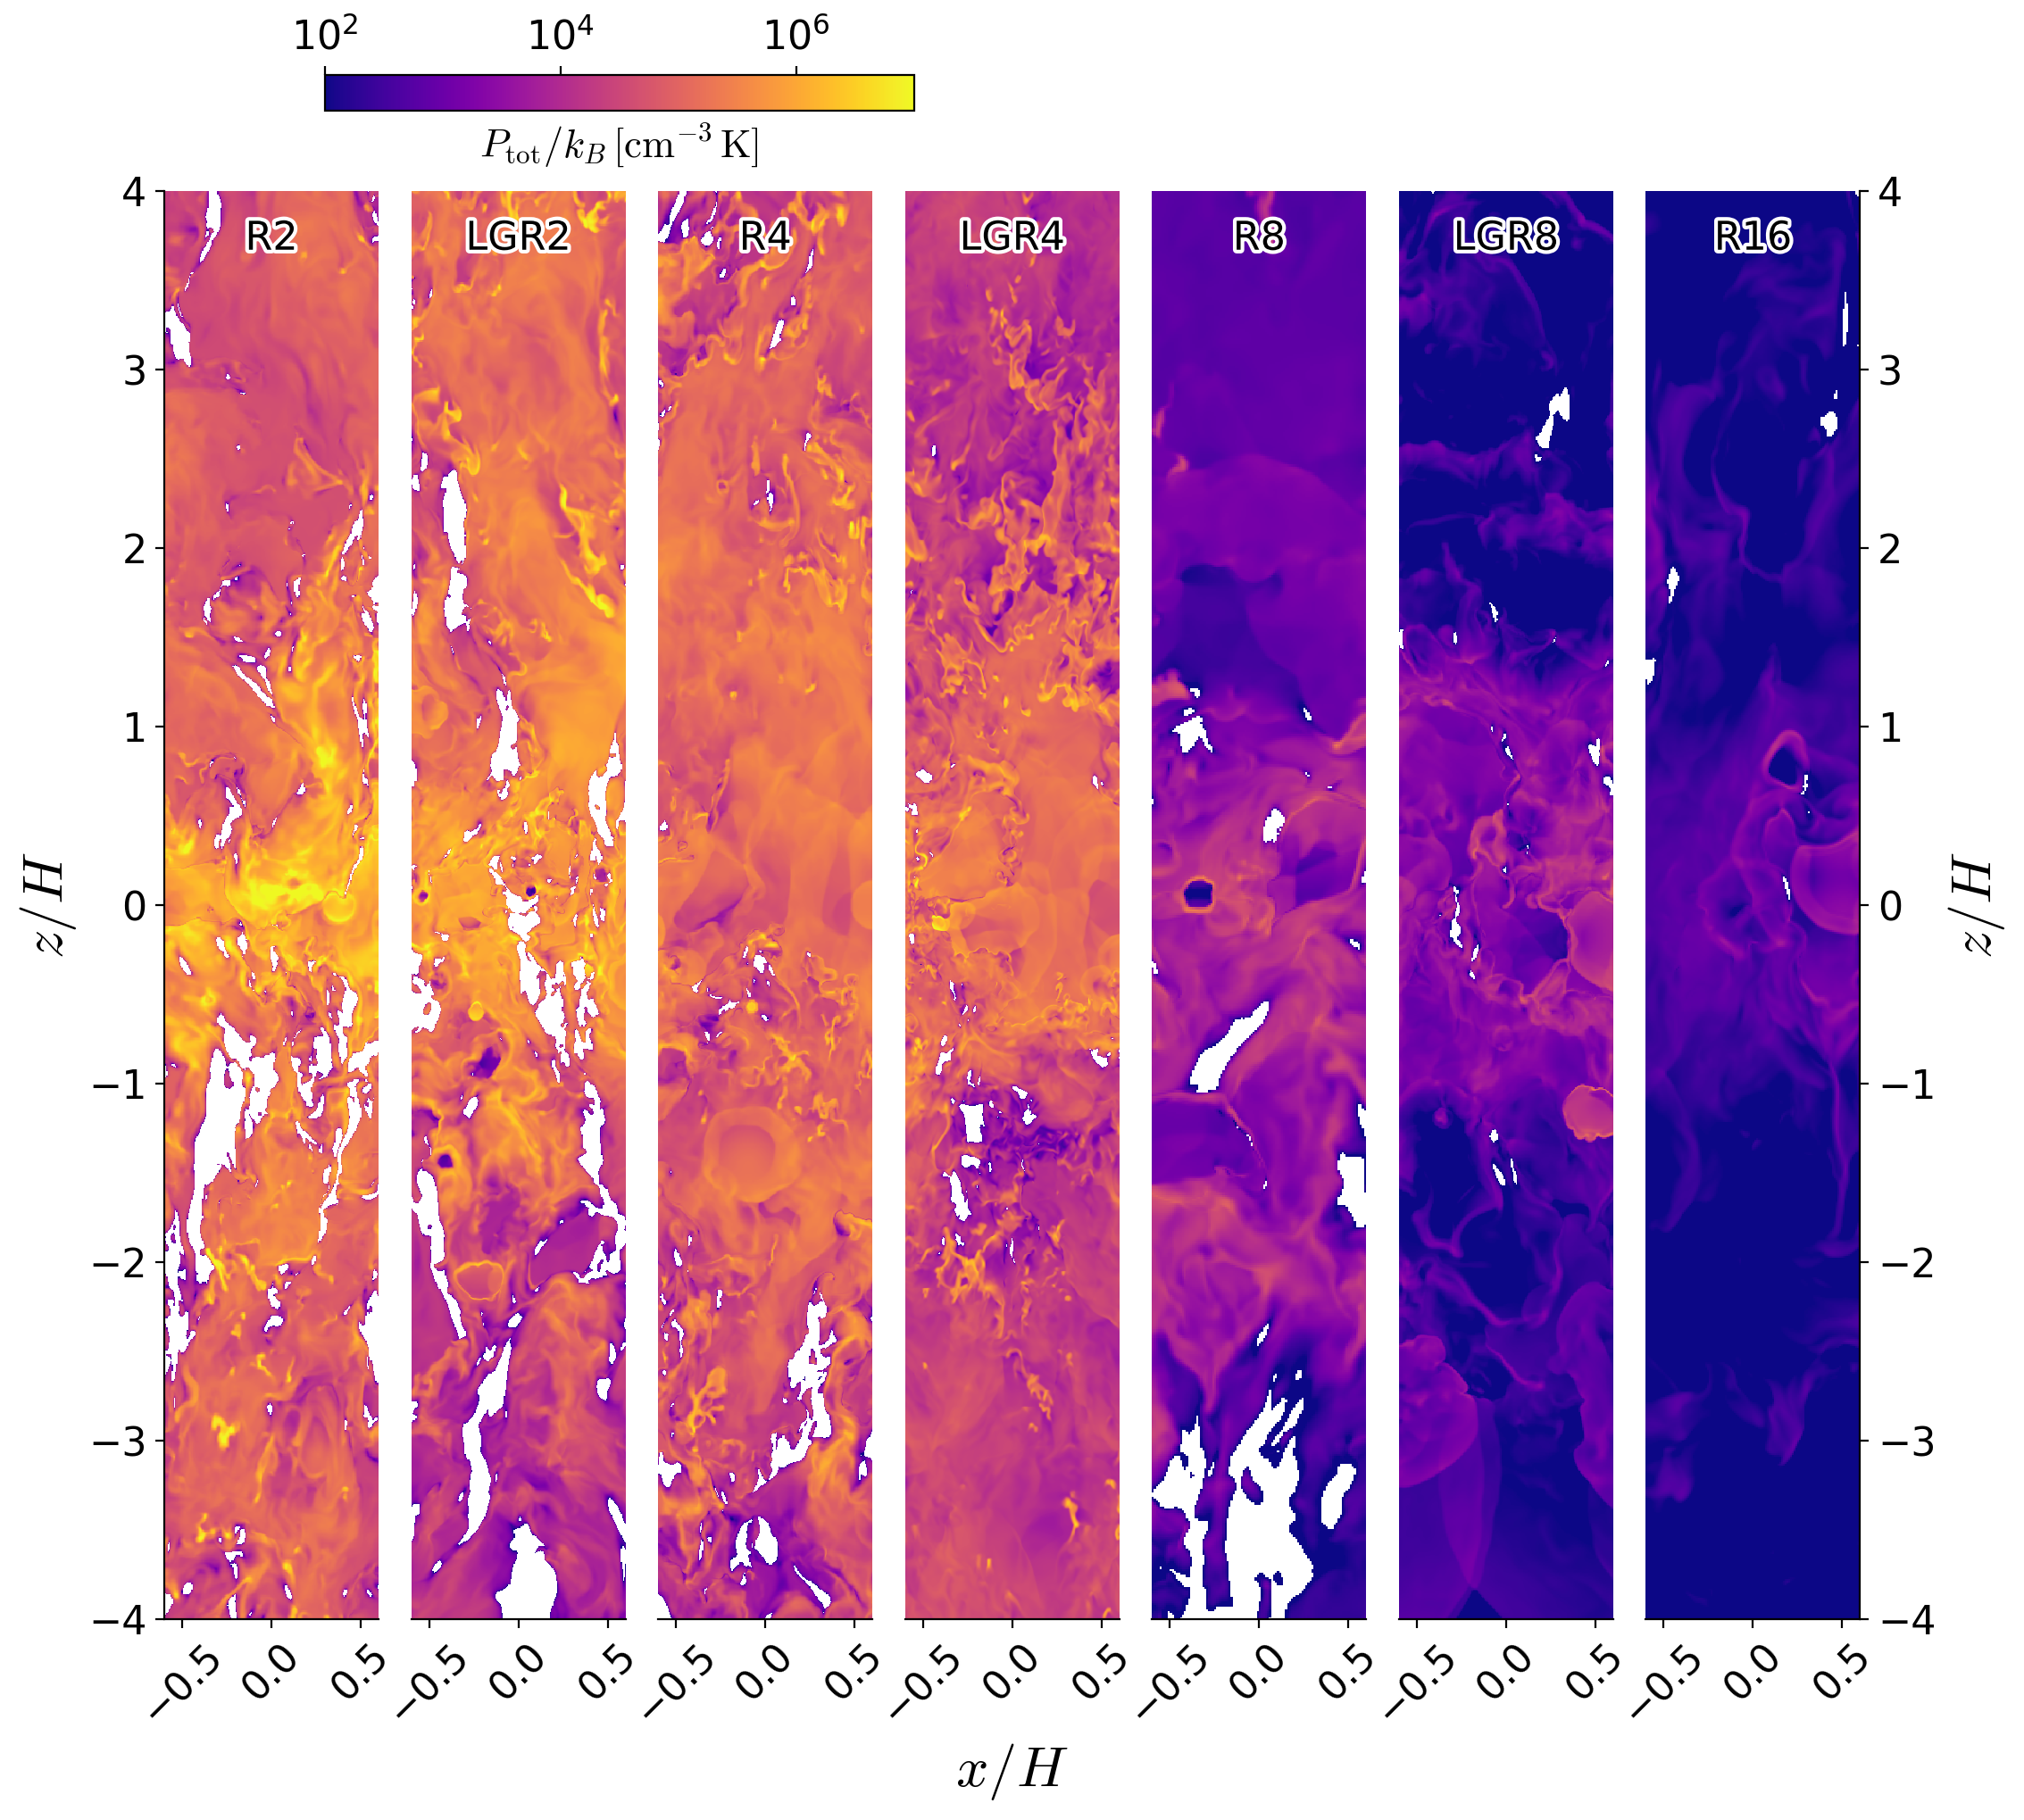

In [47]:
fig=slice_all(models,-1,'ptot','',style_light)
# figfile='../figures/slice_all_d.png'
# fig.savefig(figfile)

# slices for all P (physical legnth scales) 

In [ ]:
style_P=dict(nH=dict(norm=LogNorm(1.e-4,1.e4),cmap=cma.jungle_r,
                        label=r'$n_H$'),
                 velocity=dict(norm=SymLogNorm(linthresh=1.,vmin=-500,vmax=500),
                               cmap=cm.RdBu_r,density=2,label=r'$v_{\rm out}\,[{\rm km/s}]$'),
                 temperature=dict(norm=LogNorm(100,1.e8),cmap=cm.RdBu_r,label=r'$T$'),
                 pok=dict(norm=LogNorm(1.e2,1.e6),cmap=cm.plasma,
                          label=r'$P_{\rm th}$'),
                 ptot=dict(norm=LogNorm(1.e2,1.e6),cmap=cm.plasma,
                          label=r'$P_{\rm tot}$'),
                  ram_pok_z=dict(norm=LogNorm(1.e2,1.e6),cmap=cm.plasma,
                          label=r'$P_{\rm turb}$'),
                  mag_pok=dict(norm=LogNorm(1.e2,1.e6),cmap=cm.plasma,
                          label=r'$P_{\rm mag}$'),
                 pimag_pok=dict(norm=SymLogNorm(1.e3,vmin=-1.e6,vmax=1.e6),cmap=cm.RdBu_r,
                          label=r'$\Pi_{\rm mag}/k_B\,[{\rm cm^{-3}\,K}]$'),
                )

In [ ]:
def slice_all_P(sim,style):

#     fig,axes=plt.subplots(2,6,figsize=(12,14),num=0,
#                           sharey='row',sharex='col',
#                       gridspec_kw=dict(height_ratios=[9,1],
#                                        left=0.06,right=0.94,top=0.9,bottom=0.1,wspace=0.0))
    
    fig = plt.figure(figsize=(12,14))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(2, 6),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )
    fields=['nH','temperature','ptot','pok','ram_pok_z','mag_pok']
    for scafield,ax in zip(fields,grid.axes_row[0]): 
        cb=plot_image(sim,ax,cutaxis='y',scafield=scafield,
                      log=False,im_kw=style[scafield],colorbars=False,)

        ax.annotate(style[scafield]['label'],(0.5,1.02),xycoords='axes fraction',
                    ha='center',va='bottom',**pa.texteffect('medium'))
    cbars=[]
    for scafield,ax in zip(fields,grid.axes_row[1]): 
        cb=plot_image(sim,ax,cutaxis='z',scafield=scafield,
                      log=False,im_kw=style[scafield],colorbars=False,)
        cbars.append(cb[0])
        plt.sca(ax)
        plt.xticks(rotation=45)
        plt.xlabel(r'$x [{\rm kpc}]$')
    grid.axes_row[0][0].set_ylabel(r'$z [{\rm kpc}]$')
    grid.axes_row[1][0].set_ylabel(r'$y [{\rm kpc}]$')
    
    plt.tight_layout()
    for i,f in enumerate(fields):
        if f == 'nH':
            cax=fig.add_axes([0.94,0.70,0.02,0.25])
            cbar=fig.colorbar(cbars[i],cax=cax,orientation='vertical')
            cbar.set_label(r'$n_H\,[{\rm cm^{-3}}]$')
        if f == 'temperature':
            cax=fig.add_axes([0.94,0.4,0.02,0.25])
            cbar=fig.colorbar(cbars[i],cax=cax,orientation='vertical')
            cbar.set_label(r'$T\,[{\rm K}]$')
        if f == 'pok':
            cax=fig.add_axes([0.94,0.1,0.02,0.25])
            cbar=fig.colorbar(cbars[i],cax=cax,orientation='vertical')
            cbar.set_label(r'$P/k_B\,[{\rm cm^{-3}\,K}]$')
    return fig

In [ ]:
fig=slice_all_P(models['LGR4']['sim'],style_P)

In [ ]:
fig=slice_all_P(models['R4']['sim'],style_P)

In [ ]:
fig=slice_all_P(models['R8']['sim'],style_P)